In [3]:
### Create datafile
from zipfile import ZipFile 
import json

file_name = "yelp_academic_dataset_review.json.zip"
path = "/Volumes/My Passport/Work/yelp_dataset/"
input_zip = ZipFile(path + file_name)
del file_name

name = input_zip.namelist()[0]
data = input_zip.read(name)
del name
del input_zip

print("file read")

n = int(len(data)*(0.17/100)) # we select 0.5% of dataset
dat = data[:n]
del data
tmp = dat.decode("utf-8")
del dat
tmp = tmp.split("}\n{")
tmp[0] = tmp[0][1:]

reviews = {}
for i, r in enumerate(tmp) : 
    try : reviews[i] = json.loads("{" + r + "}")
    except : None
del tmp
# Store file
with open('yelp_reviews_part1.json', 'w', encoding='utf-8') as f:
    json.dump(reviews, f, ensure_ascii=False, indent=4)   
    
print("DONE")

file read
DONE


In [2]:
### Import (created) data
import json

with open('yelp_reviews_part1.json') as json_file:
    reviews = json.load(json_file)

print("File imported ({} reviews)".format(len(reviews)))

File imported (82211 reviews)


In [3]:
keys = list(reviews.keys())
key = keys[0]

def cleaning(text) : 
    chars_ = "'*"
    chars = "()"

    t = text.lower().replace("\n", " ").replace("\"", "")
    for c in chars_ : 
        t = t.replace(c, " ")
    for c in chars : 
        t = t.replace(c, "")

    t = " ".join([w for w in t.split(" ") if not w==""])
    
    return t

In [4]:
texts = []
for k in keys : 
    try : 
        text = reviews[k]['text']
        t = cleaning(text)
        texts.append(t)
    except : None

In [5]:
TEXT = " ".join(texts)
del reviews # free memory
TEXT[:1000]

'as someone who has worked with many museums, i was eager to visit this gallery on my most recent trip to las vegas. when i saw they would be showing infamous eggs of the house of faberge from the virginia museum of fine arts vmfa, i knew i had to go! tucked away near the gelateria and the garden, the gallery is pretty much hidden from view. it s what real estate agents would call cozy or charming - basically any euphemism for small. that being said, you can still see wonderful art at a gallery of any size, so why the two s you ask? let me tell you: pricing for this, while relatively inexpensive for a las vegas attraction, is completely over the top. for the space and the amount of art you can fit in there, it is a bit much. it s not kid friendly at all. seriously, don t bring them. the security is not trained properly for the show. when the curating and design teams collaborate for exhibitions, there is a definite flow. that means visitors should view the art in a certain sequence, wh

In [6]:
import re

occ = 10

Words = re.findall(r"[\w']+", TEXT)
WordsSet = list(set(Words))
N = len(WordsSet)

# verbose
print(str(N) + " unique words.") 
print("Let's count occurences and select only those who appears at least " + str(occ) + " times : ")

WordsCount = {}
for i, w in enumerate(WordsSet) : 
    c = Words.count(w)
    if c >= occ : # We keep words occuring at least "occ" times
        WordsCount[w] = c
    if (i+1)%2500 == 0 : print("    words done : " + str(i+1) + " (" + str(round(100*(i+1)/N)) + "%)")

numWords = len(WordsCount)
        
# verbose
print("We now have {} unique words".format(numWords))

# Store file
with open('wordscount.json', 'w', encoding='utf-8') as f:
    json.dump(WordsCount, f, ensure_ascii=False, indent=4)   
print("File stored.")

70160 unique words.
Let's count occurences and select only those who appears at least 10 times : 
    words done : 2500 (4%)
    words done : 5000 (7%)
    words done : 7500 (11%)
    words done : 10000 (14%)
    words done : 12500 (18%)
    words done : 15000 (21%)
    words done : 17500 (25%)
    words done : 20000 (29%)
    words done : 22500 (32%)
    words done : 25000 (36%)
    words done : 27500 (39%)
    words done : 30000 (43%)
    words done : 32500 (46%)
    words done : 35000 (50%)
    words done : 37500 (53%)
    words done : 40000 (57%)
    words done : 42500 (61%)
    words done : 45000 (64%)
    words done : 47500 (68%)
    words done : 50000 (71%)
    words done : 52500 (75%)
    words done : 55000 (78%)
    words done : 57500 (82%)
    words done : 60000 (86%)
    words done : 62500 (89%)
    words done : 65000 (93%)
    words done : 67500 (96%)
    words done : 70000 (100%)
We now have 16014 unique words
File stored.


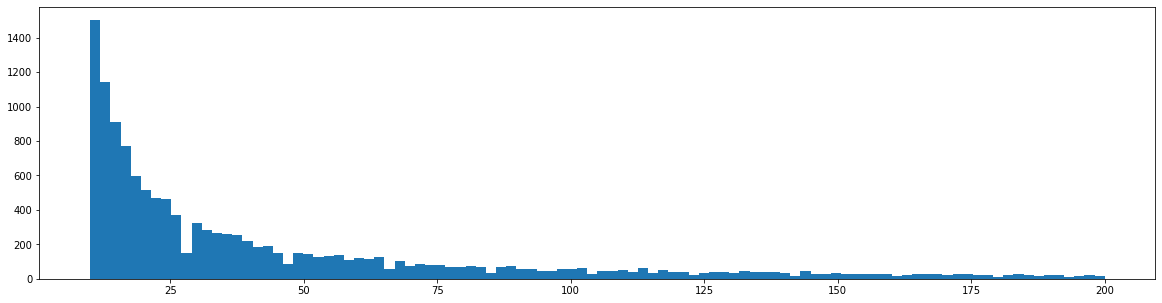

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 5))
plt.hist(WordsCount.values(), range=[occ,200], bins=100);

In [8]:
# replace word by number
WordsDict = {i:w for i, w in enumerate(list(WordsCount.keys()))}
WordsDictReverse = {v:k for k, v in WordsDict.items()}
Words = list(WordsCount.keys())

del WordsCount # free memory

In [9]:
import torch
import torch.nn as nn

class MyW2V(nn.Module):
    def __init__(self, num_words, hidden_size):
        super(MyW2V, self).__init__()
        
        self.linear1 = nn.Linear(num_words, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_words)
                
    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x


In [14]:
windowRay = 5

In [15]:
phrases = re.split(r' *[\.\?!][\'"\)\]]* *', TEXT)
trainingSet = {}
k = 0

# verbose
print("Creating training set (with window size of {})...".format(2*windowRay+1))
print(str(len(phrases)) + " phrases.")

for i, phrase in enumerate(phrases) : 
    
    # verbose
    if (i+1)%10000==0 : print("    phrases processed : " + str(i+1) + " ("+ str(round((i+1)/len(phrases)*100)) + "%)")
    
    words = re.findall(r"[\w']+", phrase)
    words = [w.lower().replace("'", " ") for w in words]

    for j in range(len(words)):
        y = words[j]
        if y in Words : 
            m = max(j-windowRay, 0)
            M = min(j+windowRay+1, len(words)-1)

            x = words[m:j] + words[(j+1):M]

            yn = WordsDictReverse[y]
            xn = [WordsDictReverse[w] for w in x if w in Words] 

        trainingSet[k] = [xn, yn]
        k += 1

print("Done")

Creating training set (with window size of 11)...
761332 phrases.
    phrases processed : 10000 (1%)
    phrases processed : 20000 (3%)
    phrases processed : 30000 (4%)
    phrases processed : 40000 (5%)
    phrases processed : 50000 (7%)
    phrases processed : 60000 (8%)
    phrases processed : 70000 (9%)
    phrases processed : 80000 (11%)
    phrases processed : 90000 (12%)
    phrases processed : 100000 (13%)
    phrases processed : 110000 (14%)
    phrases processed : 120000 (16%)
    phrases processed : 130000 (17%)
    phrases processed : 140000 (18%)
    phrases processed : 150000 (20%)
    phrases processed : 160000 (21%)
    phrases processed : 170000 (22%)
    phrases processed : 180000 (24%)
    phrases processed : 190000 (25%)
    phrases processed : 200000 (26%)
    phrases processed : 210000 (28%)
    phrases processed : 220000 (29%)
    phrases processed : 230000 (30%)
    phrases processed : 240000 (32%)
    phrases processed : 250000 (33%)
    phrases processed : 2

KeyboardInterrupt: 

In [ ]:
### Store TrainingSet
with open('trainingset.json', 'w', encoding='utf-8') as f:
    json.dump(trainingSet, f, ensure_ascii=False, indent=4)   
 

In [ ]:
del TEXT # Free Memory

In [15]:
### Import training set
import json

with open('trainingset.json') as json_file:
    trainingSet = json.load(json_file)

In [16]:
def onehot(lst, N) : 
    return [1*(i in lst) for i in range(N)]

In [26]:
NUM_WORDS = numWords
NUM_HIDDEN = 128

model = MyW2V(NUM_WORDS, NUM_HIDDEN)
loss = nn.CrossEntropyLoss()

import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0)


In [27]:
import random
from datetime import datetime

In [44]:
def getData(batch) : 
    X = [t[0] for t in batch]
    X_onehot = [onehot(x, N=numWords) for x in X]
    X = torch.FloatTensor(X_onehot)
    
    Y = [t[1] for t in batch]
    Y = torch.tensor(Y).reshape(-1)
    
    return X, Y   

def getLoss(X, Y):
    pred = model.forward(X)
    output = loss(pred, Y)
    return output

def createBatches(dataSet, batch_size):
    batches = []
    j=0
    while j < len(dataSet) : 
        batch = dataSet[j:min(j+BATCH_SIZE, len(dataSet)-1)]
        j += BATCH_SIZE
        
        X, Y = getData(batch)
        
        batches.append([X, Y])
        
    return batches

In [46]:
BATCH_SIZE = 64

trainingSetList = list(trainingSet.values())
del trainingSet # free memory

testSet = random.sample(trainingSetList, round(0.01*len(trainingSetList)))
Xtest, Ytest = getData(testSet)

totalLoss = float(getLoss(Xtest, Ytest))
# verbose
print("Epoch 0 : ")
print("    - Loss : " + str(round(totalLoss, ndigits=4)))

epoch = 0

trainingSet0 = random.sample(trainingSetList, len(trainingSetList))
del trainingSetList # free memory
t1 = datetime.now()
batches = createBatches(trainingSet0, BATCH_SIZE)
del trainingSet0 # free memory
t2 = datetime.now()  - t1
duration = t2.seconds // 60

# verbose
print("Batches created. Duration : " + str(duration) + " min.")
    
for _ in range(100):
    
    epoch += 1
    
    t1 = datetime.now()
    
    #batches = random.sample(batches, len(batches))
    
    for batch in batches : 

        X, Y = batch
        output = getLoss(X, Y)

        optimizer.zero_grad()
        output.backward(retain_graph=True)
        optimizer.step()

    t2 = datetime.now()  - t1
    duration = t2.seconds // 60
    
    if epoch%10 == 0 : 
    
        totalLoss = float(getLoss(Xtest, Ytest))

        print("Epoch " + str(epoch) + " : ")
        print("    - Batch size : " + str(BATCH_SIZE))
        print("    - Loss : " + str(round(totalLoss, ndigits=4)))
        print("    - Duration : " + str(duration) + " min.")
        
del batches # free memory

Epoch 0 : 
    - Loss : 8.8706
Batches created. Duration : 8 min.
Epoch 10 : 
    - Batch size : 64
    - Loss : 3.8953
    - Duration : 2 min.
Epoch 20 : 
    - Batch size : 64
    - Loss : 3.2776
    - Duration : 2 min.
Epoch 30 : 
    - Batch size : 64
    - Loss : 3.0122
    - Duration : 2 min.
Epoch 40 : 
    - Batch size : 64
    - Loss : 2.8775
    - Duration : 2 min.
Epoch 50 : 
    - Batch size : 64
    - Loss : 2.7984
    - Duration : 2 min.
Epoch 60 : 
    - Batch size : 64
    - Loss : 2.7467
    - Duration : 2 min.
Epoch 70 : 
    - Batch size : 64
    - Loss : 2.7099
    - Duration : 2 min.
Epoch 80 : 
    - Batch size : 64
    - Loss : 2.6822
    - Duration : 2 min.
Epoch 90 : 
    - Batch size : 64
    - Loss : 2.6608
    - Duration : 2 min.
Epoch 100 : 
    - Batch size : 64
    - Loss : 2.644
    - Duration : 2 min.


In [49]:
import pandas as pd

df = pd.DataFrame({'word' : list(WordsDict.values()),
                   'num' : list(WordsDict.keys())})
df = pd.concat([df, pd.DataFrame(model.linear1.weight.data.numpy()).transpose()], axis=1)

In [50]:
df.head()

,word,num,0,1,2,3,4,5,6,7,...,118,119,120,121,122,123,124,125,126,127
0,corned,0,0.026023,-0.302686,0.716478,1.760051,1.166899,-0.153824,-0.940575,0.027834,...,-0.487021,-0.555046,0.254399,-1.070017,1.447841,1.340765,0.318240,0.876247,1.235983,-0.705773
1,garlicky,1,-1.576522,-1.323343,-0.641931,-1.068634,0.611991,0.391321,-0.758668,-0.857353,...,-1.106937,-1.164347,0.279036,-0.430467,1.378840,2.385134,-1.398105,0.982056,-1.549440,0.026775
2,german,2,0.769606,-0.875350,0.073682,-0.019873,1.460747,-0.061882,0.209817,-0.827818,...,0.377502,-0.344845,0.583333,-1.617766,0.175091,0.661808,0.682916,-0.005390,-0.584258,0.335614
3,eight,3,-0.364568,-0.257157,0.036172,-0.305355,0.437882,-1.602795,-0.654901,0.845419,...,0.370201,-0.063870,-0.641261,-1.762030,1.441150,-1.061864,1.663599,0.093128,-0.495082,1.556980
4,shown,4,1.159035,-2.261499,0.972445,-0.082260,1.013518,0.301240,-0.781852,-1.491687,...,1.549682,-1.033483,0.910200,-1.549716,1.810117,-1.269402,-1.289852,-0.600029,-1.090389,0.454459


In [60]:
df.to_csv("myW2V.csv", index=False)

In [55]:
df_viz = df.sample(20)
df_viz.head()

from sklearn import decomposition

# dim reduc : ACP
X = df_viz.iloc[:,2:].values

pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

n = len(X)
X1 = [X[i][0] for i in range(n)]
X2 = [X[i][1] for i in range(n)]




Explained information : 19%



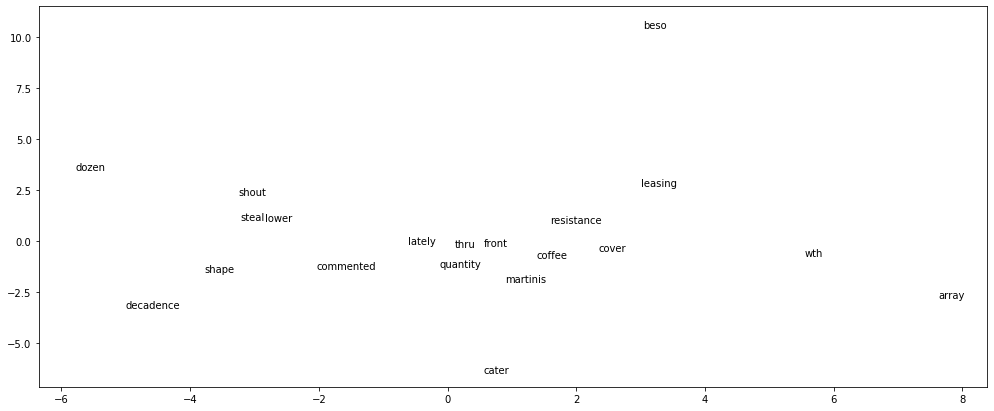

In [56]:
import matplotlib.pyplot as plt
words = df_viz.iloc[:,0].values

print("\nExplained information : " + str(int(100*sum(pca.explained_variance_ratio_))) + "%\n")

fig = plt.figure(figsize=(17, 7))
plt.axis([min(X1)*1.1, max(X1)*1.1, min(X2)*1.1, max(X2)*1.1])
for w, x, y in zip(words, X1, X2):
    plt.text(x, y, w)

# Self Attention

In [465]:
### prepare dataset

# Import (created) data
import json

with open('yelp_reviews_part1.json') as json_file:
    reviews = json.load(json_file)

print("File imported ({} reviews)".format(len(reviews)))

# prepare data

File imported (4102 reviews)


In [466]:
wordsList = df['word'].tolist()

dataSet = {}
k = 0

keys = list(reviews.keys())
for key in keys :
    try :
        text = reviews[key]['text']
        words = re.findall(r"[\w']+", text)
        words = [w.lower().replace("'", " ") for w in words if w in wordsList]
        tmp = df[df['word'].isin(words)]
        vectors = [tmp[tmp['word'] == w].iloc[0,2:].tolist() for w in words]
        
        star = reviews[key]['stars']
        
        dataSet[k] = [vectors, star]
        k += 1
      
    except : None

print("DONE")
        
del reviews # free memory    

DONE


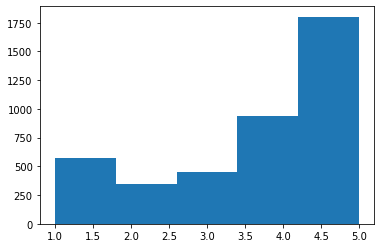

In [467]:
stars = [dataSet[k][1] for k in list(dataSet.keys())]
plt.hist(stars, align='mid', bins=5);

In [543]:
splitRatio = 0.05

dataSize = len(dataSet)
indices = random.sample(range(dataSize), round(splitRatio*dataSize))

keys = list(dataSet.keys())
testSet = [dataSet[keys[i]] for i in indices]
trainSet = [dataSet[keys[i]] for i in range(dataSize) if i not in indices]

# verbose
print("Training set size : {}\nTest set size : {}\n".format(dataSize-len(indices), len(indices)))

Training set size : 3897
Test set size : 205



In [544]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
from torch.autograd import Variable

import unicodedata
import string

from itertools import chain



class EncoderRNN(nn.Module):
    def __init__(self, input_dim, h_dim, batch_first=True):
        super(EncoderRNN, self).__init__()
        self.h_dim = h_dim
        self.lstm = nn.LSTM(input_dim, h_dim, batch_first=batch_first,
                            bidirectional=True)

    def init_hidden(self, b_size):
        h0 = Variable(torch.zeros(1*2, b_size, self.h_dim))
        c0 = Variable(torch.zeros(1*2, b_size, self.h_dim))
        return (h0, c0)

    def forward(self, x):
        self.hidden = self.init_hidden(x.size(0))
        packed_emb = x

        out, hidden = self.lstm(packed_emb, self.hidden)
                
        out = out[:, :, :self.h_dim] + out[:, :, self.h_dim:]
        
        return out


class Attn(nn.Module):
    def __init__(self, h_dim):
        super(Attn, self).__init__()
        self.h_dim = h_dim
        self.main = nn.Sequential(
            nn.Linear(h_dim, 24),
            nn.ReLU(True),
            nn.Linear(24,1)
        )

    def forward(self, encoder_outputs):
        b_size = encoder_outputs.size(0)
        attn_ene = self.main(encoder_outputs.view(-1, self.h_dim)) # (b, s, h) -> (b * s, 1)
        return F.softmax(attn_ene.view(b_size, -1), dim=1).unsqueeze(2) # (b*s, 1) -> (b, s, 1)

class AttnClassifier(nn.Module):
    def __init__(self, h_dim, c_num):
        super(AttnClassifier, self).__init__()
        self.attn = Attn(h_dim)
        self.main = nn.Linear(h_dim, c_num)
        
    
    def forward(self, encoder_outputs):
        attns = self.attn(encoder_outputs) #(b, s, 1)
        feats = (encoder_outputs * attns).sum(dim=1) # (b, s, h) -> (b, h)
        #output = F.softmax(self.main(feats))
        output = self.main(feats)
        return output, attns


In [545]:
# make model
encoder = EncoderRNN(128, 32)
classifier = AttnClassifier(32, 1)

# optim
optimizer = optim.Adam(chain(encoder.parameters(),classifier.parameters()), lr=0.001)


In [546]:
loss = nn.MSELoss()
#loss = nn.CrossEntropyLoss()

In [547]:
encoder.train()
classifier.train()
correct = 0
dataList = trainSet
print(str(len(dataList)) + " reviews to train on.")
for j in range(50) :
    for i, data in enumerate(dataList):
        x, y = data
        if len(x)>0 : 
            x = torch.Tensor(x)
            x = x.view(1, -1, 128)
            #y = torch.tensor(y-1).reshape(-1).type(torch.LongTensor)
            y = torch.tensor(y).reshape(-1)
            optimizer.zero_grad()
            encoder_outputs = encoder(x)
            output, attn = classifier(encoder_outputs)
            los = loss(output, y)
            los.backward()
            optimizer.step()

    if (j+1)%10==0 : 
        # calculate error on test set
        Y = []
        Ypred = []
        for test in testSet : 
            try :
                Xtest = torch.Tensor(test[0])
                Xtest = Xtest.view(1, -1, 128)
                encoder_outputs = encoder(Xtest)
                output, attn = classifier(encoder_outputs)
                Ypred.append(output[0][0].detach().numpy())
                Y.append(test[1])
            except : None
        
        err = np.mean([abs(y-min(5, max(1, round(float(ypred))))) for y, ypred in zip(Y, Ypred)])
        
        # Verbose
        print("    {} epochs done. Error : {}".format(j+1, round(err, ndigits=6)))

# verbose
print("Training done.")

3897 reviews to train on.
    10 epochs done. Error : 0.702439


KeyboardInterrupt: 

In [548]:
print("test phase")

Y = []
Ypred = []
for test in testSet : 
    try :
        Xtest = torch.Tensor(test[0])
        Xtest = Xtest.view(1, -1, 128)
        encoder_outputs = encoder(Xtest)
        output, attn = classifier(encoder_outputs)
        Ypred.append(output[0][0].detach().numpy())
        #Ypred.append(torch.max(output, 1)[1][0].detach().numpy())
        Y.append(test[1])
    except : None

print("Done")

test phase
Done


In [549]:
import numpy as np
np.mean([abs(y-round(float(ypred))) for y, ypred in zip(Y, Ypred)])
#np.mean([abs(y-ypred) for y, ypred in zip(Y, Ypred)])

0.6487804878048781

In [550]:
Yval = list(set(Y))
Yval.sort()

confmat = []

for y in Yval :
    lst = [0, 0, 0, 0, 0]
    for i in range(len(Y)) : 
        if Y[i] == y :
            ypred = min(max(1, round(float(Ypred[i]))), 5)
            lst[int(ypred-1)] += 1
    confmat.append(lst)



In [551]:
np.array(confmat).T

array([[12,  4,  1,  0,  3],
       [10,  7,  5,  2,  2],
       [ 5,  3,  5,  9,  4],
       [ 3,  0,  7, 24, 20],
       [ 0,  1,  2, 17, 59]])

In [552]:
sum([confmat[i][i] for i in range(5)])/len(Y)*100

52.19512195121951

In [553]:
confmat2 = confmat
for i in range(5):
    for j  in range(5) : 
        confmat2[i][j] = round(confmat[i][j]/len(Y)*100)

In [554]:
np.array(confmat2).T

array([[ 6,  2,  0,  0,  1],
       [ 5,  3,  2,  1,  1],
       [ 2,  1,  2,  4,  2],
       [ 1,  0,  3, 12, 10],
       [ 0,  0,  1,  8, 29]])

# Vizualisation

In [463]:
test = testSet[6]
Xtest = torch.Tensor(test[0])
Xtest = Xtest.view(1, -1, 128)
test[1]

KeyError: 6

In [394]:
encoder_outputs = encoder(Xtest)
output, attn = classifier(encoder_outputs)
output

tensor([[5.1325]], grad_fn=<AddmmBackward>)

In [396]:
a = attn.data[0,:,0]
a

tensor([3.4873e-02, 2.5949e-03, 2.1146e-04, 3.4034e-04, 1.7443e-02, 4.3202e-01,
        1.2596e-03, 8.5964e-04, 2.1628e-01, 4.4622e-05, 9.9330e-03, 2.9967e-05,
        1.4599e-06, 2.6095e-05, 5.5018e-04, 3.2486e-02, 8.0658e-06, 2.7958e-03,
        2.1654e-06, 1.0675e-07, 1.0591e-07, 6.0541e-08, 1.3530e-05, 2.0220e-09,
        5.7851e-11, 2.9865e-09, 1.1099e-03, 1.3531e-02, 1.4685e-05, 2.0168e-05,
        1.5390e-08, 2.9074e-03, 3.1314e-08, 3.9030e-03, 1.0896e-04, 8.3598e-02,
        5.1319e-06, 3.9162e-07, 6.6421e-09, 8.1745e-04, 6.2547e-04, 2.8928e-05,
        4.3990e-06, 6.1138e-05, 1.2171e-05, 2.9681e-02, 1.1179e-01, 1.2083e-06,
        6.4868e-07, 3.3909e-06, 4.2358e-09])

In [555]:
# Import (created) data
import json

with open('yelp_reviews_part1.json') as json_file:
    reviews = json.load(json_file)

print("File imported ({} reviews)".format(len(reviews)))

keys = list(reviews.keys())

File imported (4102 reviews)


In [556]:
text = reviews[keys[6]]['text']
text

'Really good place with simple decor, amazing food and great hospitality.\nVery impressed with the lunch portion. Although service took little extra time but I have no complaints since they are quite new in business. The green curry chicken was good and to the right spice balance I asked for. I will definitely recommend this place to others.'

In [559]:
wordsList = df['word'].tolist()

words = re.findall(r"[\w']+", text)
words = [w.lower().replace("'", " ") for w in words if w in wordsList]
tmp = df[df['word'].isin(words)]
vectors = [tmp[tmp['word'] == w].iloc[0,2:].tolist() for w in words]

x = torch.tensor(vectors).view(1, -1, 128)
encoder_outputs = encoder(x)
output, attn = classifier(encoder_outputs)



In [562]:
round(float(output))

5

In [407]:
def highlight(word, attn):
    html_color = '#%02X%02X%02X' % (255, int(255*(1 - attn)), int(255*(1 - attn)))
    return '<span style="background-color: {}">{}</span>'.format(html_color, word)

def mk_html(sentence, attns):
    html = ""
    for word, attn in zip(sentence, attns):
        html += ' ' + highlight(
            word,
            attn
        )
    return html + "<br><br>\n"

In [600]:

k = 4

text = reviews[keys[k]]['text']
star = reviews[keys[k]]['stars']

wordsList = df['word'].tolist()

words = re.findall(r"[\w']+", text)
words = [w.lower().replace("'", " ") for w in words if w in wordsList]
tmp = df[df['word'].isin(words)]
vectors = [tmp[tmp['word'] == w].iloc[0,2:].tolist() for w in words]

x = torch.tensor(vectors).view(1, -1, 128)
encoder_outputs = encoder(x)
output, attn = classifier(encoder_outputs)

starpred = min(max(1, round(float(output))), 5)

a = attn.data[0,:,0]


words = re.findall(r"[\w']+", text)
words = [w.lower().replace("'", " ") for w in words if w in wordsList]

wordsLst = []
wordsAttn = []
i = 0
j = 0
k = 0
w =  words[k]
l = len(w)
while i < len(text):
    wt = text[i:(i+l)]
    if wt.lower().replace("'", " ").replace("\n", "") == w : 
        wordsLst.append(text[j:i])
        wordsAttn.append(0)
        wordsLst.append(wt)
        wordsAttn.append(float(a[k]))
        i = i+l
        j = i
        k += 1
        try : 
            w =  words[k]
            l = len(w)
        except : break
    else :
        i += 1

In [601]:
f = open("attn.html", "w")
f.write( '\t'.join([str(int(star)), str(starpred), mk_html(wordsLst, wordsAttn)]))
f.close()

In [602]:
starpred

3

In [599]:
text

'Dismal, lukewarm, defrosted-tasting "TexMex" glop;\n\nMumbly, unengaged waiter;\n\nClueless manager, who seeing us with barely nibbled entrees\non plates shoved forward for pickup, thanked us\nperfunctorily for our patronage;\n\nWe\'re from the Texas Hill Country;\ndown there, we jail critters \nwho serve up grub this bad,\nfor their own protection.\n\nNever, never, NEVER again\n(Back to Yard House for real food)'

In [565]:
text

'Really good place with simple decor, amazing food and great hospitality.\nVery impressed with the lunch portion. Although service took little extra time but I have no complaints since they are quite new in business. The green curry chicken was good and to the right spice balance I asked for. I will definitely recommend this place to others.'

In [427]:
w

'place'

In [569]:
wordsIn

{'Really ': 0,
 'good': 0.008519185706973076,
 ' ': 0,
 'place': 8.057260743044026e-07,
 'with': 0.00010041088535217568,
 'simple': 1.8584192730486393e-05,
 'decor': 0.043511517345905304,
 ', ': 0,
 'amazing': 0.2592686414718628,
 'food': 0.002137534786015749,
 'and': 3.22355299431365e-06,
 'great': 0.31096503138542175,
 'hospitality': 0.003158975625410676,
 '.\nVery ': 0,
 'impressed': 0.0008085811859928071,
 'the': 1.8984486871431727e-07,
 'lunch': 0.013776425272226334,
 'portion': 0.007655754219740629,
 '. Although ': 0,
 'service': 0.00029548941529355943,
 'took': 1.7773362515072222e-06,
 'little': 4.475287198602018e-07,
 'extra': 3.3218679163837805e-05,
 'time': 1.5490697478526272e-05,
 'but': 7.776482561894227e-06,
 ' I ': 0,
 'have': 0.0008112172945402563,
 'no': 0.002674650400876999,
 'complaints': 2.2990123397903517e-05,
 'since': 0.0007223040447570384,
 'they': 0.008232345804572105,
 'are': 0.0005870381137356162,
 'quite': 0.019895952194929123,
 'new': 0.02636522799730301,
 '